In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import ema, anet
from evolutions import *
from utils import stack_imgs
from evaluation import *
import PIL

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## MNIST

In [3]:
from utils import get_dataset_MNIST as get_dataset
from config_mnist import get_configs
config = get_configs()
config.data.norm_mean = (0.0)
config.data.norm_std = (1.0)

device = torch.device('cpu')
train_loader, val_loader = get_dataset(config)

In [4]:
x,y = next(iter(train_loader))

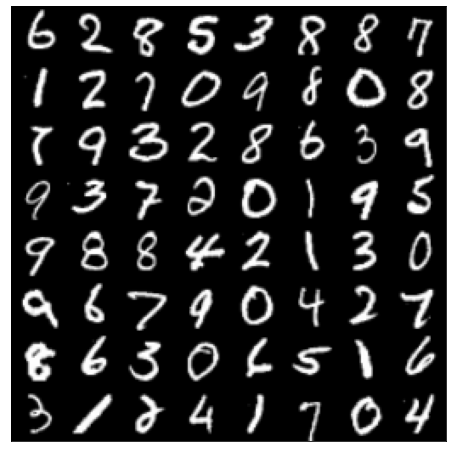

In [5]:
figsize(10,8)
big_img = stack_imgs(x[:64])
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

In [15]:
def dct(x, norm=None):
    B, N = x.shape
    v = torch.cat([x[:, ::2], x[:, 1::2].flip([1])], dim=1)

    Vc = torch.fft.fft(v, dim=1)

    k = - torch.arange(N, dtype=x.dtype, device=x.device)[None, :] * np.pi / (2 * N)
    W_r = torch.cos(k)
    W_i = torch.sin(k)

    V = Vc.real * W_r - Vc.imag * W_i

    if norm == 'ortho':
        V[:, 0] /= np.sqrt(N) * 2
        V[:, 1:] /= np.sqrt(N / 2) * 2

    V = 2 * V.view(B,N)
    return V

def idct(X, norm=None):
    x_shape = X.shape
    N = x_shape[-1]

    X_v = X.contiguous().view(-1, x_shape[-1]) / 2

    if norm == 'ortho':
        X_v[:, 0] *= np.sqrt(N) * 2
        X_v[:, 1:] *= np.sqrt(N / 2) * 2

    k = torch.arange(x_shape[-1], dtype=X.dtype, device=X.device)[None, :] * np.pi / (2 * N)
    W_r = torch.cos(k)
    W_i = torch.sin(k)

    V_t_r = X_v
    V_t_i = torch.cat([X_v[:, :1] * 0, -X_v.flip([1])[:, :-1]], dim=1)

    V_r = V_t_r * W_r - V_t_i * W_i
    V_i = V_t_r * W_i + V_t_i * W_r
    
    v = torch.fft.ifft(V_r + V_i*1j, dim=1).real
    x = v.new_zeros(v.shape)
    x[:, ::2] += v[:, :N - (N // 2)]
    x[:, 1::2] += v.flip([1])[:, :N // 2]
    return x.view(*x_shape)

def dct_2d(x, norm=None):
    B, C, H, W = x.shape
    x = x.reshape(B*C, H, W)
    x1 = dct(x.reshape(B*C*H, W), norm=norm)
    x1 = x1.reshape(B*C, H, W).transpose(-1, -2)
    x2 = dct(x1.reshape(B*C*H, W), norm=norm)
    return x2.reshape(B, C, H, W).transpose(-1, -2)

def idct_2d(x, norm=None):
    B, C, H, W = x.shape
    x = x.reshape(B*C, H, W)
    x1 = idct(x.reshape(B*C*H, W), norm=norm)
    x1 = x1.reshape(B*C, H, W).transpose(-1, -2)
    x2 = idct(x1.reshape(B*C*H, W), norm=norm)
    return x2.reshape(B, C, H, W).transpose(-1, -2)

def heat_eq_forward(u, t):
    B, C, H, W = u.shape
    sigma_min, sigma_max = 1e-1, 20
    freqs = math.pi * torch.linspace(0, H-1, H)/H
    frequencies_squared = freqs[:, None]**2 + freqs[None, :]**2
    frequencies_squared = frequencies_squared.unsqueeze(0).unsqueeze(0)
    t = t[:, None, None, None]
    u_proj = dct_2d(u, norm='ortho')
    t_prime = 0.5*torch.exp(2*(t*math.log(sigma_max) + (1-t)*math.log(sigma_min)))
    u_proj = torch.exp(-frequencies_squared*t_prime)*u_proj
    u_reconstucted = idct_2d(u_proj, norm='ortho')
    return u_reconstucted

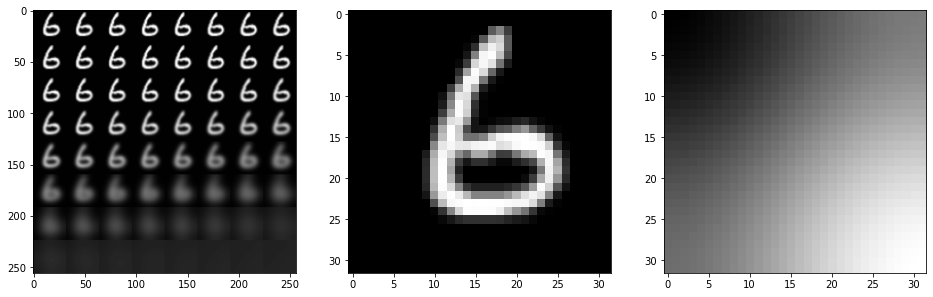

In [16]:
figsize(16,8)

batch = x[:1].repeat([64,1,1,1])
heated_batch = heat_eq_forward(batch, torch.linspace(0,1,64))
img = np.zeros([8*32,8*32])
k = 0
for k in range(64):
    i, j = k//8, k % 8
    img[i*32:(i+1)*32,j*32:(j+1)*32] = heated_batch[k]
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(img[0:32,0:32], cmap='gray')
plt.subplot(133)
plt.imshow(img[i*32:(i+1)*32,j*32:(j+1)*32], cmap='gray')

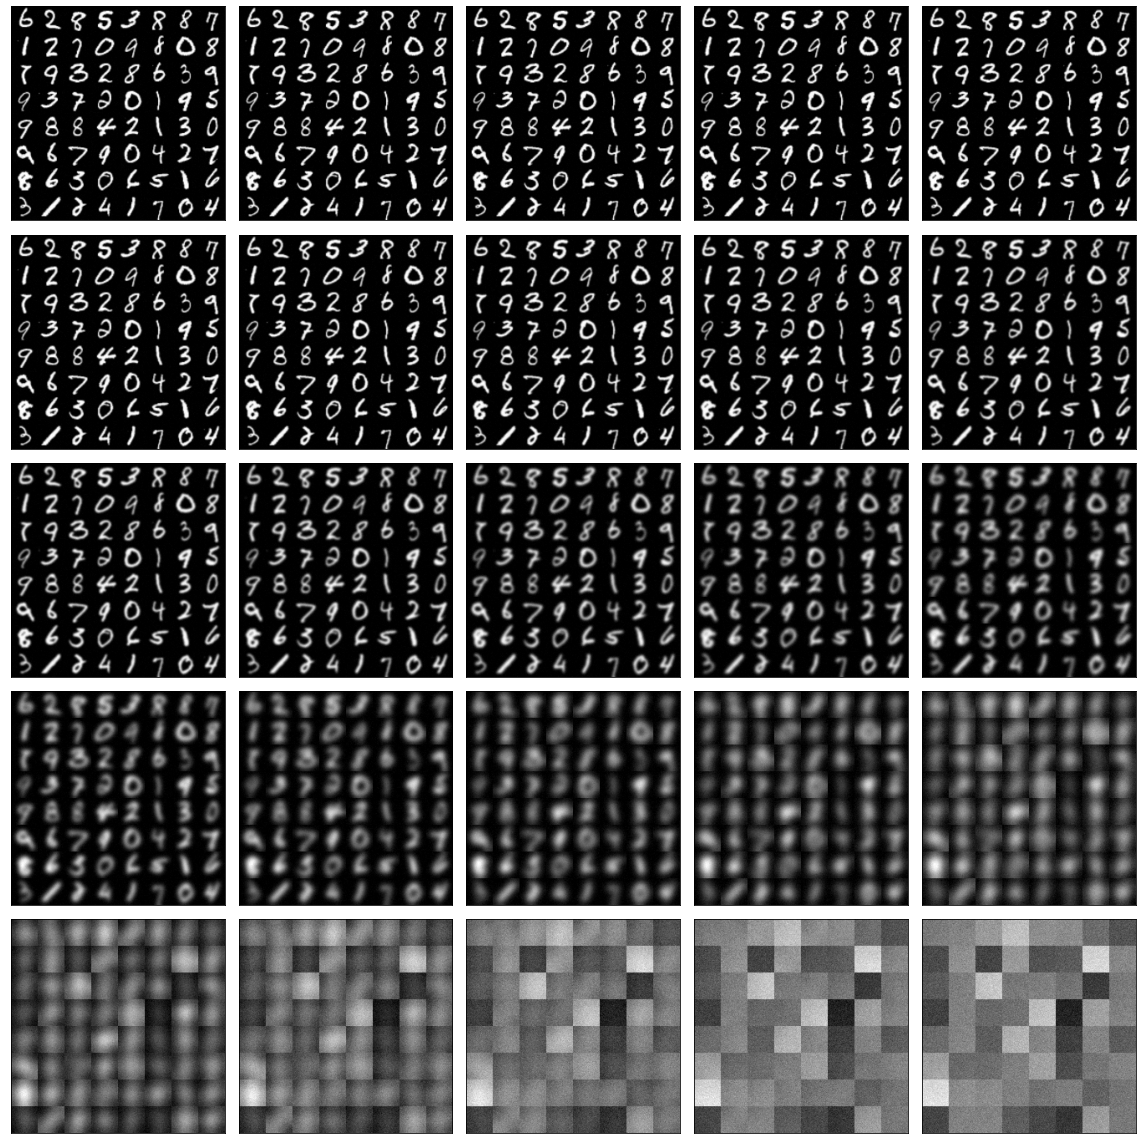

In [17]:
figsize(16,16)
t = np.linspace(0,1,25)
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,5*i+j+1)
        img = heat_eq_forward(x[:64], torch.ones(64)*t[5*i+j])
        img = img + 1e-2*torch.randn_like(img)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(stack_imgs(img), cmap='gray')
plt.tight_layout()

In [189]:
stds, means = [], []
for x,y in train_loader:
    heated_batch = heat_eq_forward(x, torch.ones(x.shape[0]))
    stds.append(heated_batch.std(dim=[1,2,3]))
    means.append(heated_batch.mean(dim=[1,2,3]))
stds, means = torch.concat(stds), torch.concat(means)

In [ ]:
from scipy.stats import gaussian_kde

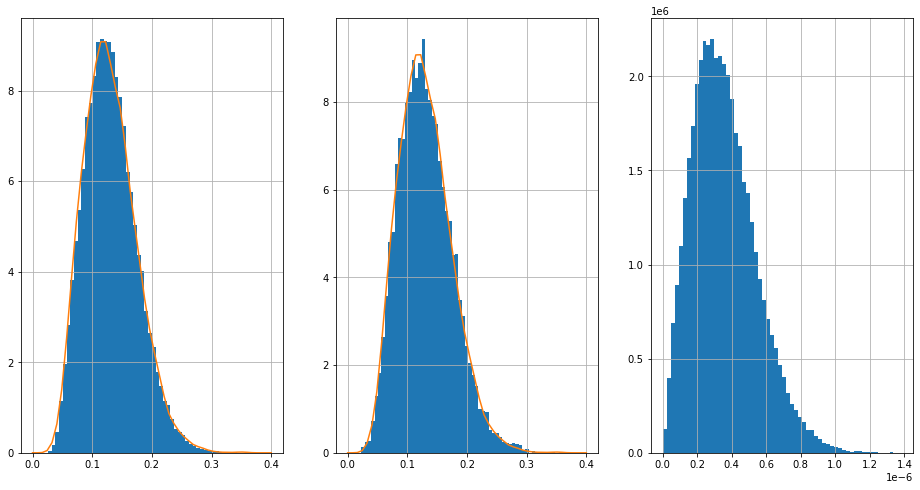

In [259]:
plt.subplot(131)
plt.hist(means.numpy(), bins=60, density=True)
kernel = gaussian_kde(means.numpy()[:5000])
range_ = np.linspace(0.0, 0.4)
plt.plot(range_, kernel.pdf(range_))
plt.grid()
plt.subplot(132)
plt.hist(kernel.resample(10000).flatten(), bins=60, density=True)
plt.plot(range_, kernel.pdf(range_))
plt.grid()
plt.subplot(133)
plt.hist(stds.numpy(), bins=60, density=True)
plt.grid()

In [246]:
x,y = next(iter(train_loader))
print(x.mean(dim=[1,2,3]) - heat_eq_forward(x, torch.ones(x.shape[0])).mean(dim=[1,2,3]))

tensor([ 1.4901e-08,  0.0000e+00,  0.0000e+00,  1.4901e-08, -7.4506e-09,
        -7.4506e-09,  0.0000e+00,  0.0000e+00,  0.0000e+00,  7.4506e-09,
         0.0000e+00,  0.0000e+00, -1.4901e-08,  0.0000e+00,  7.4506e-09,
        -7.4506e-09,  0.0000e+00, -2.9802e-08,  0.0000e+00, -1.4901e-08,
        -2.2352e-08, -1.4901e-08,  1.4901e-08,  0.0000e+00, -7.4506e-09,
         1.4901e-08,  0.0000e+00,  0.0000e+00, -7.4506e-09, -7.4506e-09,
         0.0000e+00,  1.4901e-08,  0.0000e+00,  0.0000e+00, -1.4901e-08,
         0.0000e+00, -7.4506e-09, -2.2352e-08,  0.0000e+00,  0.0000e+00,
        -1.4901e-08, -3.7253e-09,  7.4506e-09,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.4901e-08,  1.4901e-08, -2.9802e-08,  0.0000e+00,
         2.9802e-08,  1.4901e-08, -4.4703e-08, -2.9802e-08, -7.4506e-09,
         0.0000e+00,  2.9802e-08, -2.9802e-08, -1.4901e-08, -7.4506e-09,
        -7.4506e-09,  2.2352e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -7.4506e-09,  0.0000e+00,  1.4901e-08,  1.4